In [29]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [30]:
df = pd.read_csv('stud.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Target Column : Math Score 

In [31]:
X = df.drop(columns=['math_score'],axis = 1)
y = df['math_score']

X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [32]:
# y

In [33]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [34]:
num_features = X.select_dtypes(exclude='object').columns.tolist()
cat_features = X.select_dtypes(include = 'object').columns.tolist()

print("Numerical Features" , num_features)
print("Categorical Features" , cat_features)

Numerical Features ['reading_score', 'writing_score']
Categorical Features ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']


#### Scaling and Encoding. Scaling Numerical Features and Encoding Categorical Features

In [35]:
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()
preprocessor  = ColumnTransformer(
    [
      ('OneHotEncoder' ,num_transformer  ,num_features), 
      ('StandardScaler' , cat_transformer ,cat_features)    
    ]
    )

preprocessor


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('OneHotEncoder', ...), ('StandardScaler', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``f

In [36]:
X = preprocessor.fit_transform(X)


In [37]:
feature_names = preprocessor.get_feature_names_out()

### Train-Test Split of data

In [38]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train  , y_test = train_test_split(X , y , test_size=0.25 , random_state=42)
x_train.shape , x_test.shape

((750, 19), (250, 19))

### Evaluate Model 

In [39]:
def evaluate_model(true ,predicted):
    mae  = mean_absolute_error(true,predicted)
    mse  = mean_squared_error(true,predicted)
    r2_square = r2_score(true, predicted)
    return mae ,mse , r2_square

In [40]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [50]:
results = []
all_feature_importances = {}
for name,model in models.items():
    model.fit(x_train,y_train) # train models
    
    y_train_pred = model.predict(x_train) # predictions
    y_test_pred = model.predict(x_test)
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    results.append({
        "Model": name,
        "Train_R2": model_train_r2*100,
        "Test_R2": model_test_r2*100,
        "Train_RMSE": model_train_rmse,
        "Test_RMSE": model_test_rmse
    })
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        # Map them together
        fi_df = pd.DataFrame({'Feature': feature_names, 'Value': importance})
        # print(f"Top features for {name}:")
        fi_df.sort_values(by='Value', ascending=False).head()
    
    
results_df = pd.DataFrame(results).sort_values(by='Test_R2',ascending=False)

# results_df
# all_feature_importances
fi_df.sort_values(by='Value', ascending=False).head(10)

results_df


,Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE
2,Ridge,87.425811,87.799014,28.064180,30.017316
0,Linear Regression,87.427324,87.782431,28.060804,30.058115
7,CatBoosting Regressor,96.115510,85.482952,8.669745,35.715379
5,Random Forest Regressor,97.645874,84.556098,5.254146,37.995658
8,AdaBoost Regressor,85.010673,84.023961,33.454498,39.304841
6,XGBRegressor,99.654394,83.790410,0.771358,39.879429
1,Lasso,80.768679,82.002780,42.922153,44.277425
3,K-Neighbors Regressor,84.998912,79.421624,33.480747,50.627680
4,Decision Tree,99.962662,76.678669,0.083333,57.376000


## Feature Importance

C:\Users\Yash0607\AppData\Local\Temp\ipykernel_1412\2968632508.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df_sorted, x='Value', y='Feature', palette='viridis')


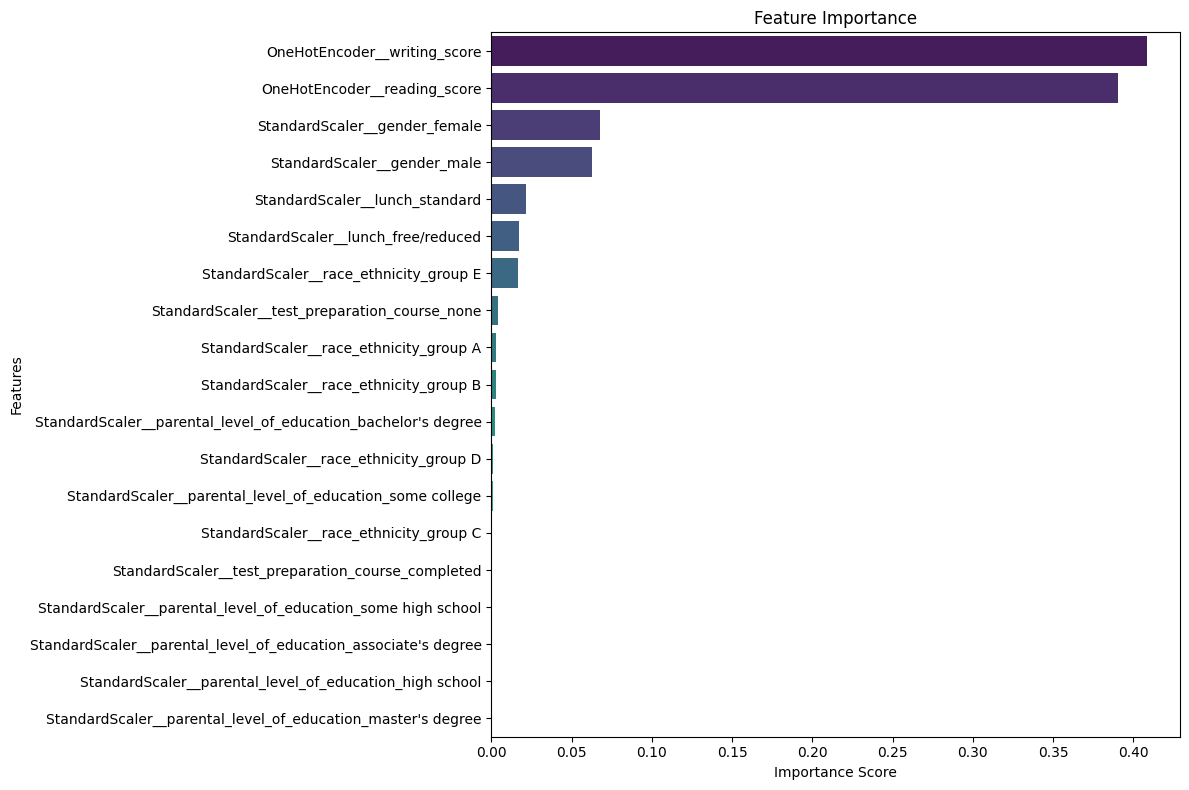

In [56]:
# 1. Sort the DataFrame so the most important features are at the top
fi_df_sorted = fi_df.sort_values(by='Value', ascending=False)

# 2. Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=fi_df_sorted, x='Value', y='Feature', palette='viridis')

# 3. Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### Difference Between Actual and Predicted Values

In [58]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Difference':y_test-y_test_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,77.656863,13.343137
737,53,56.633333,-3.633333
740,80,77.747312,2.252688
660,74,76.919192,-2.919192
411,84,83.054545,0.945455
...,...,...,...
109,70,59.732240,10.267760
430,64,62.160920,1.839080
77,80,79.281818,0.718182
84,42,38.000000,4.000000


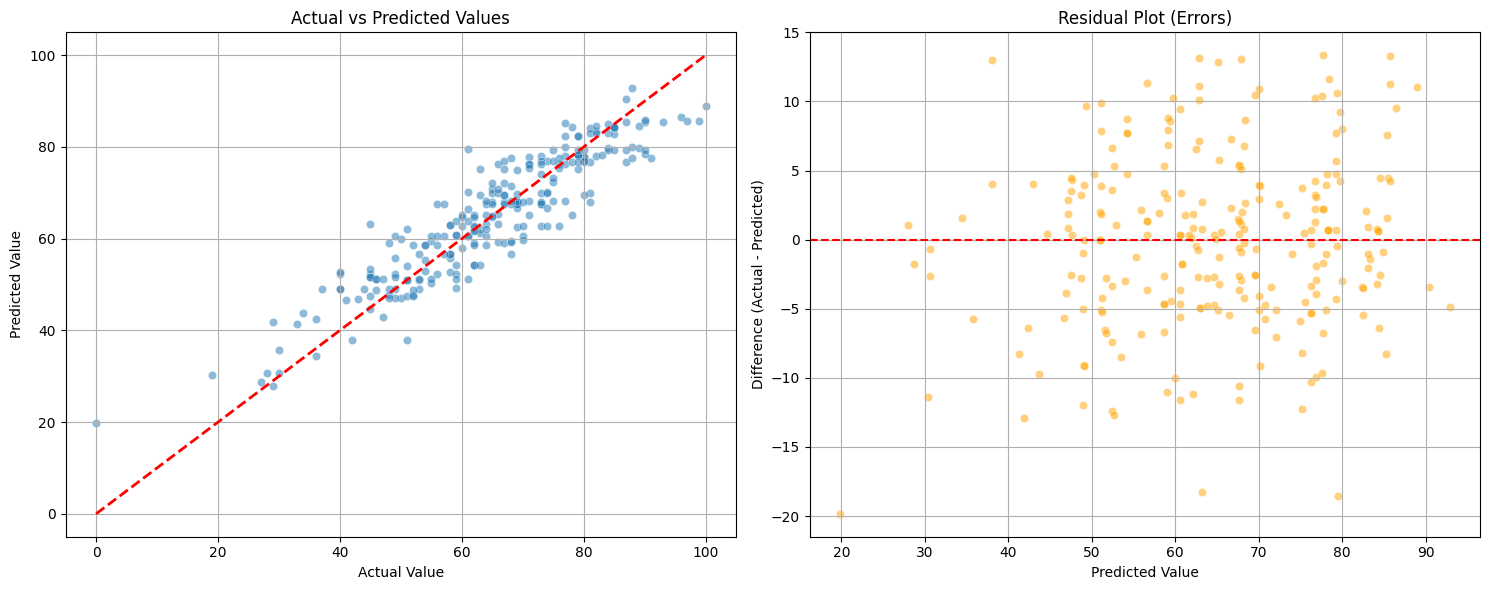

In [61]:
# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# 1. Scatter Plot: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(data=pred_df, x='Actual Value', y='Predicted Value', alpha=0.5)
# Add a diagonal line to show where a perfect prediction would be
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Values')
plt.grid(True)

# 2. Residual Plot: Predicted vs Difference (Error)
plt.subplot(1, 2, 2)
sns.scatterplot(data=pred_df, x='Predicted Value', y='Difference', color='orange', alpha=0.5)
# Add a horizontal line at 0 (where error is zero)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (Errors)')
plt.ylabel('Difference (Actual - Predicted)')
plt.grid(True)

plt.tight_layout()
plt.show()